In [1]:
import sys
from os import path 

scriptpath = ".."
sys.path.append(path.abspath(scriptpath))

from slp import Parser
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate

from imblearn.over_sampling import RandomOverSampler

from tpot import TPOTClassifier

import torch
import matplotlib.pyplot as plt
from collections import defaultdict

RANDOM = 1620 # Bacon's scientific method is born
TPOT = False
OH_DIMENSION = 200
EPOCHS = 500

torch.manual_seed(RANDOM)
np.random.seed(RANDOM)

In [2]:
with open('../data/nl2bash.cm') as f1:
    benign = f1.readlines()

with open('../data/malicious.cm') as f2:
    malicious = f2.readlines()

In [3]:
# heavily imbalanced data - as always in security ...
print(len(benign))
print(len(malicious))

12607
123


# Encoding using `bashprocessing`

In [4]:
Xcm, y = shuffle(benign + malicious, \
                [0] * len(benign) + [1] * len(malicious), \
                random_state=RANDOM)

print("[!] Preprocessing of dataset...")
p = Parser(verbose=True)
cntr, corpus = p.tokenize(Xcm)
X = p.encode(mode="onehot", top_tokens=OH_DIMENSION)
y = np.array(y).astype(int)


[!] Preprocessing of dataset...


# Oversampling

If we train model on data as is we get really high accuracy score (due to fast that our dataset have small amount of malicious examples, predicting always negative will results into really hihg accuracy)..

In [5]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)

y_pred = rfc.predict(X)
print(accuracy_score(y, y_pred))


0.9974076983503535


In [6]:
def class_percentage(y):
    u,c = np.unique(y, return_counts=True)
    neg,pos = c
    print(f"Malicious commands: {round(pos*100/(neg+pos),4)} %")

print("\nIn dataset set:\n\t", end="")
class_percentage(y)


In dataset set:
	Malicious commands: 0.9662 %


Therefore, we need to implement oversampling, so model is able to train itself on malicious examples.

In [7]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM)

X_resampled, y_resampled = ros.fit_resample(X, y)

In [8]:
print(X.shape)
print(X_resampled.shape)

(12730, 200)
(25214, 200)


In [9]:
print("\nIn resampled train set:\n\t", end="")
class_percentage(y_resampled)


In resampled train set:
	Malicious commands: 50.0 %


# Cross-Validation

We just can't use sklearn's `train_test_split()` as is, because many malicious behavior commands have totally different pattern and purpose. Therefore, we need to find specific command subset, that characterize some family of malicious commands, and is in necessary amount to be present in both train and test sets.

Instead we will use cross validation, which gradually shifts training and test sets across all data corpus.

![image info](../img/cv.png)

In [30]:
FOLDS = 5

rfc = RandomForestClassifier(n_estimators=200)

scores = cross_validate(rfc, X, y, cv=FOLDS,\
                        scoring=('accuracy', 'precision', 'recall'),
                        return_train_score=True)


In [31]:
for score in scores:
    if 'time' not in score:
        print(f"\n{score}:")
        print("\t",round(np.mean(scores[score]),4),"%")


test_accuracy:
	 0.9946 %

train_accuracy:
	 0.9974 %

test_precision:
	 0.8234 %

train_precision:
	 0.9222 %

test_recall:
	 0.569 %

train_recall:
	 0.8029 %


# Attempt to use Deep Learning

In [12]:
X_trainT = torch.from_numpy(np.array(X_resampled, dtype='float32'))
y_trainT = torch.from_numpy(np.array(y_resampled, dtype='float32'))

## Arcihtecture selection

Trying to overfit model with small batch to understand, whether model can learn perfectly nonlinearity of the data.

In [36]:
hidden_nodes = [16, 64, 256]

In [37]:
models = defaultdict(dict)

for n in hidden_nodes:
    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n,1),
        torch.nn.Sigmoid()
    )
    models[f"onelayer-hn{str(n)}"] = m

    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n, int(n/2), bias=True),
        torch.nn.BatchNorm1d(int(n/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(n/2),1),
        torch.nn.Sigmoid()
    )
    models[f"twolayers-hn{str(n)}"] = m

    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n, int(n/2), bias=True),
        torch.nn.BatchNorm1d(int(n/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(n/2),int(n/2)),
        torch.nn.BatchNorm1d(int(n/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(n/2),1),
        torch.nn.Sigmoid()
    )
    models[f"threelayers-hn{str(n)}"] = m

In [38]:
print(models[list(models.keys())[-1]])
print("\nTotal amount of models: ",len(models))

Sequential(
  (0): Linear(in_features=200, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
  (10): Sigmoid()
)

Total amount of models:  9


In [25]:
def plot_loss(loss_dict, title="Losses over number of epochs", lim=None):
    plt.title(title)
    for loss in loss_dict:
        plt.plot(loss_dict[loss][0:], label=loss)
    plt.xlabel('number of epochs')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    if lim:
        plt.ylim(lim)
    plt.show()

In [40]:
loss_values = defaultdict(list)
for model in models:
    print(f"[!] Training {model} model..")
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(models[model].parameters())
    for ep in range(1000):
        optimizer.zero_grad()
        output = models[model].forward(X_trainT[0:32])
        loss = criterion(output, y_trainT[0:32])
        loss.backward()
        optimizer.step()

        loss_values[model].append(loss.item()/32)

[!] Training onelayer-hn16 model..
[!] Training twolayers-hn16 model..
[!] Training threelayers-hn16 model..
[!] Training onelayer-hn64 model..
[!] Training twolayers-hn64 model..
[!] Training threelayers-hn64 model..
[!] Training onelayer-hn256 model..
[!] Training twolayers-hn256 model..
[!] Training threelayers-hn256 model..


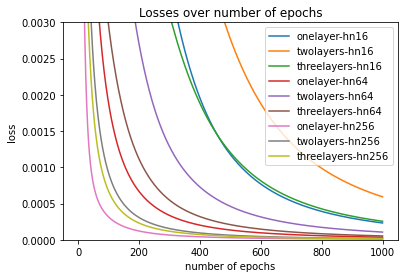

In [41]:
plot_loss(loss_values, lim=(0,0.003))

From here we see that for model in order to learn pattern in a data it's more important is to have higher number of nodes in a layer, than depth.  

All models with 64 nodes eventually were able to learn pattern almost perfectly, with no noticeable difference between two and three layers. More shallow models even after 1000 operations are not able to learn it perfectly, which means they're unable to get all level of data nonlinearity.

Try one more iteration of one layer models, with wider range of nodes.

In [42]:
hidden_nodes = [32, 64, 128, 256, 512, 1024]
models = defaultdict(dict)

for n in hidden_nodes:
    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n,1),
        torch.nn.Sigmoid()
    )
    models[f"onelayer-hn{str(n)}"] = m


In [43]:
loss_values = defaultdict(list)
for model in models:
    print(f"[!] Training {model} model..")
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(models[model].parameters())
    for ep in range(1000):
        optimizer.zero_grad()
        output = models[model].forward(X_trainT[0:32])
        loss = criterion(output, y_trainT[0:32])
        loss.backward()
        optimizer.step()

        loss_values[model].append(loss.item()/32)

[!] Training onelayer-hn32 model..
[!] Training onelayer-hn64 model..
[!] Training onelayer-hn128 model..
[!] Training onelayer-hn256 model..
[!] Training onelayer-hn512 model..
[!] Training onelayer-hn1024 model..


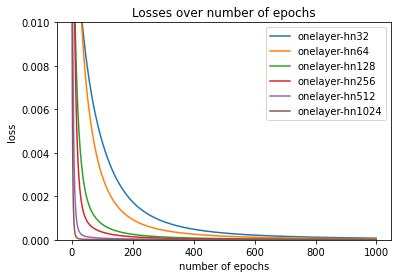

In [44]:
plot_loss(loss_values, lim=(0,0.01))

Ok, having one layer with 256 nodes seem to be optimal. Increasing number of hidden nodes above that yields no noticeable results. 

## Hyperparameter tuning

In order to test Learning Rate we add some basic regularization (actual rate tuned below) as it affects how loss fluctuates as well.

In [45]:
learning_rates = [0.0003, 0.001, 0.003, 0.01, 0.03]

In [46]:
N = 256

model = torch.nn.Sequential(
    torch.nn.Linear(OH_DIMENSION, N, bias=True),
    torch.nn.BatchNorm1d(N),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.35),
    torch.nn.Linear(N,1),
    torch.nn.Sigmoid()
    )

def weight_reset(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

In [47]:
loss_values = defaultdict(list)
for lr in learning_rates:
    model.apply(weight_reset)
    print(f"[!] Training optimal model with lr: {lr}")
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for ep in range(200):
        optimizer.zero_grad()
        output = model.forward(X_trainT)
        loss = criterion(output, y_trainT)
        loss.backward()
        optimizer.step()

        loss_values[lr].append(loss.item()/len(y_trainT))

[!] Training optimal model with lr: 0.0003
[!] Training optimal model with lr: 0.001
[!] Training optimal model with lr: 0.003
[!] Training optimal model with lr: 0.01
[!] Training optimal model with lr: 0.03


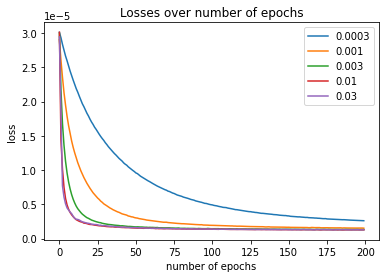

In [48]:
plot_loss(loss_values)

Increase in Learning Rate does not bring loss perturbations (at least in \[0.0003:0.03\] range), although no noticeable benefit in noticed above 0.003 value. Considering this as optimal value. 

## Dropout regularization

In [13]:
dropout = [0.2, 0.5, 0.7]

In [22]:
N = 256
EPOCHS = 500
models = defaultdict(dict)

models["no_dropout"] = model = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, N, bias=True),
        torch.nn.BatchNorm1d(N),
        torch.nn.ReLU(),
        torch.nn.Linear(N, 1),
        torch.nn.Sigmoid())

for rate in dropout:
    model = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, N, bias=True),
        torch.nn.BatchNorm1d(N),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=rate),
        torch.nn.Linear(N, 1),
        torch.nn.Sigmoid()
    )
    models[rate] = model

In [23]:
loss_values = defaultdict(list)

for model in models: 
    #print(f"[!] Training: {model}")
    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(models[model].parameters(), lr=0.003)

    for ep in range(EPOCHS):
        if ep & 255 == 0:
               print(f"{model} epoch: {ep}")
        optimizer.zero_grad()
        output = models[model].forward(X_trainT)

        loss = criterion(output, y_trainT)
        loss.backward()
        optimizer.step()

        loss_values[model].append(loss.item()/len(y_trainT))

no_dropout epoch: 0
no_dropout epoch: 256
0.2 epoch: 0
0.2 epoch: 256
0.5 epoch: 0
0.5 epoch: 256
0.7 epoch: 0
0.7 epoch: 256


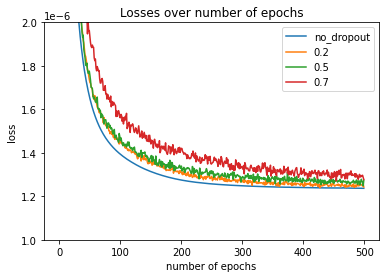

In [32]:
plot_loss(loss_values, lim=(1e-6,2e-6))

# Real Training

In [33]:
N = 256
DROPOUT = 0.5
OPTIMAL_LR = 0.003
EPOCHS = 10000

model = torch.nn.Sequential(
    torch.nn.Linear(OH_DIMENSION, N, bias=True),
    torch.nn.BatchNorm1d(N),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=DROPOUT),
    torch.nn.Linear(N, 1),
    torch.nn.Sigmoid()
)

loss_values = defaultdict(list)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=OPTIMAL_LR)

for ep in range(EPOCHS):
    if ep & 255 == 0:
        print("epoch:",ep)
        
    optimizer.zero_grad()
    output = model.forward(X_trainT)

    loss = criterion(output, y_trainT)
    loss.backward()
    optimizer.step()

    loss_values[f'HN: {N}, DR: {DROPOUT}, LR: {OPTIMAL_LR}'].append(loss.item()/len(y_trainT))

epoch: 0
epoch: 256
epoch: 512
epoch: 768
epoch: 1024
epoch: 1280
epoch: 1536
epoch: 1792
epoch: 2048
epoch: 2304
epoch: 2560
epoch: 2816
epoch: 3072
epoch: 3328
epoch: 3584
epoch: 3840
epoch: 4096
epoch: 4352
epoch: 4608
epoch: 4864
epoch: 5120
epoch: 5376
epoch: 5632
epoch: 5888
epoch: 6144
epoch: 6400
epoch: 6656
epoch: 6912
epoch: 7168
epoch: 7424
epoch: 7680
epoch: 7936
epoch: 8192
epoch: 8448
epoch: 8704
epoch: 8960
epoch: 9216
epoch: 9472
epoch: 9728
epoch: 9984


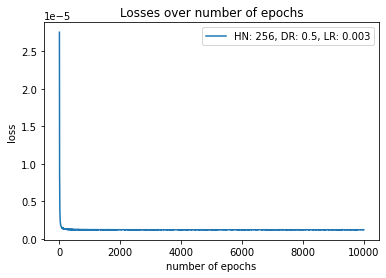

In [34]:
plot_loss(loss_values)

In [40]:
torch.save(model.state_dict(),"model_256hn_0.5dropout_0.003lr_10000epochs")

In [45]:
model_weights = torch.load("model_256hn_0.5dropout_0.003lr_10000epochs")
type(model_weights)

collections.OrderedDict

It is clearly seen that model does not improves after first few dozens of epochs.  
This is due to *small amout of data*.  

~12k of data might be sufficient to train some classical Machine Learning model, but obviously not enough to get all power of Neural Network nonlinearity.  

Therefore, attempt to use TPOT autoML approach was used.

# Trying TPOT

TPOT evaluated pipeline is exported to `security_classification_tpot_pipeline.py`.

In [ ]:
if TPOT: # may skip as is long (takes ~3.5 hours)
    tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
    tpot.fit(X_train, y_train)
    tpot.score(np.array(X_test), np.array(y_test))